<a href="https://colab.research.google.com/github/catnipglitch/google-colab-notebooks-catnip/blob/main/colab_sample/Get_started_copied.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API: Getting started with Gemini 2.0

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

新しい **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** は、[Gemini Developer API](https://ai.google.dev/gemini-api/docs) および [Vertex AI 上の Gemini API](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) を通じて [Gemini モデル](https://ai.google.dev/gemini-api/docs/models) への統一されたインターフェースを提供します。いくつかの例外を除き、どちらのプラットフォームでも同じコードが動作します。このノートブックでは Developer API を使用します。

このノートブックでは、以下の内容を順に説明します：

* Google GenAI SDK の[インストールとセットアップ](Get_started.ipynb#scrollTo=Mfk6YY3G5kqp)
* [テキスト](Get_started.ipynb#scrollTo=6TYNPrNvQ8ue)および[マルチモーダル](#scrollTo=yww-vrxmRiIy)プロンプト
* [トークン数のカウント](Get_started.ipynb#scrollTo=_9B8pb7tv_Cx)
* システムインストラクションの設定
* [セーフティフィルタ](Get_started.ipynb#scrollTo=HTAnYx_bbxPk)の設定
* [マルチターンチャット](Get_started.ipynb#scrollTo=HTAnYx_bbxPk)の開始
* [生成出力の制御](Get_started.ipynb#scrollTo=nyZMoM6tgnTA)
* [関数呼び出し](Get_started.ipynb#scrollTo=Rl-y9SZywD0s)の利用
* [コンテンツストリーム](Get_started.ipynb#scrollTo=uQfLCxfQtPTg)の生成と[非同期リクエスト](Get_started.ipynb#scrollTo=plCtEIaHuv96)の送信
* [ファイルアップロード](Get_started.ipynb#scrollTo=enBhuaIk3KYa)の利用
* [コンテキストキャッシュ](Get_started.ipynb#scrollTo=oTgeR3_9wN5J)の利用
* [テキスト埋め込み](Get_started.ipynb#scrollTo=sXNCRn8Wx71d)の生成

この新しい SDK の詳細は[ドキュメント](https://ai.google.dev/gemini-api/docs/sdks)をご覧ください。

## Setup

### Install SDK

[PyPI](https://github.com/googleapis/python-genai) から SDK をインストールします。

In [1]:
%pip install -U -q 'google-genai>=1.4.0' # 1.4.0 is needed for chat history

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 6.4 MB/s eta 0:00:00


### Setup your API key

以下のセルを実行するには、API キーを Colab Secret の `GOOGLE_API_KEY` に保存しておく必要があります。API キーをまだ持っていない場合や Colab Secret の作成方法が分からない場合は、[認証方法](../quickstarts/Authentication.ipynb)の例を参照してください。

In [2]:
from google.colab import userdata

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

### Initialize SDK client

新しい SDK では、API キー（または [Vertex AI](https://cloud.google.com/vertex-ai) を利用する場合は OAuth）でクライアントを初期化するだけで済みます。モデルは各呼び出しごとに指定します。

In [3]:
from google import genai
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY)

### Choose a model

このガイドで使用するモデルを選択してください。リストから選択するか、モデル名を手動で入力できます。2.5系のモデルなど一部は「thinking model」となっており、応答にやや時間がかかる場合があります。詳細は [thinking notebook](./Get_started_thinking.ipynb) を参照してください。

すべての Gemini モデルの概要は[ドキュメント](https://ai.google.dev/gemini-api/docs/models/gemini)をご覧ください。

In [4]:
MODEL_ID = "gemini-2.5-flash-preview-04-17" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash-preview-04-17","gemini-2.5-pro-exp-03-25"] {"allow-input":true, isTemplate: true}

## Send text prompts

`generate_content` メソッドを使ってプロンプトへの応答を生成します。テキストを直接 `generate_content` に渡し、`.text` プロパティで応答のテキスト内容を取得できます。出力が1つのパートのみの場合、`.text` フィールドが利用できます。

In [7]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents="What's the largest planet in our solar system?"
)

Markdown(response.text)

The largest planet in our solar system is **Jupiter**.

## Count tokens

トークンは Gemini モデルへの基本的な入力単位です。`count_tokens` メソッドを使うと、Gemini API にリクエストを送る前に入力トークン数を計算できます。

In [ ]:
response = client.models.count_tokens(
    model=MODEL_ID,
    contents="What's the highest mountain in Africa?",
)

print(response)

## Send multimodal prompts

Gemini 2.0 モデル（`gemini-2.0-flash-exp`）はマルチモーダルプロンプトをサポートしています。テキスト、[PDF ドキュメント](../quickstarts/PDF_Files.ipynb)、画像、[音声](../quickstarts/Audio.ipynb)、[動画](../quickstarts/Video.ipynb)をプロンプトに含めて、テキストやコードの応答を得ることができます。

最初の例では、指定した URL から画像をダウンロードし、バイトストリームとして保存し、そのバイトをローカルファイル `jetpack.png` に書き込みます。

In [ ]:
import requests
import pathlib
from PIL import Image

IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png" # @param {type: "string"}

img_bytes = requests.get(IMG).content

img_path = pathlib.Path('jetpack.png')
img_path.write_bytes(img_bytes)

In this second example, you'll open a previously saved image, create a thumbnail of it and then generate a short blog post based on the thumbnail, displaying both the thumbnail and the generated blog post.

In [ ]:
from IPython.display import display, Markdown
image = Image.open(img_path)
image.thumbnail([512,512])

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        image,
        "Write a short and engaging blog post based on this picture."
    ]
)

display(image)
Markdown(response.text)

## Configure model parameters

各モデル呼び出し時にパラメータ値を指定して、応答の生成方法を制御できます。[パラメータ値の調整方法](https://ai.google.dev/gemini-api/docs/text-generation?lang=node#configure)の詳細も参照してください。

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="Tell me how the internet works, but pretend I'm a puppy who only understands squeaky toys.",
    config=types.GenerateContentConfig(
        temperature=0.4,
        top_p=0.95,
        top_k=20,
        candidate_count=1,
        seed=5,
        max_output_tokens=100,
        stop_sequences=["STOP!"],
        presence_penalty=0.0,
        frequency_penalty=0.0,
    )
)

print(response.text)

## Configure safety filters

Gemini API では複数のカテゴリでセーフティフィルタを調整でき、特定の種類のコンテンツを制限または許可できます。これらのフィルタを使って、用途に応じた適切な出力を得ることができます。詳細は[セーフティフィルタの設定](https://ai.google.dev/gemini-api/docs/safety-settings)ページを参照してください。

この例では、危険度の高いコンテンツのみをブロックするセーフティフィルタを使い、失礼なフレーズの生成をリクエストします。

In [ ]:
prompt = """
    Write a list of 2 disrespectful things that I might say to the universe after stubbing my toe in the dark.
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

response = client.models.generate_content(
    model=MODEL_ID,
    contents=prompt,
    config=types.GenerateContentConfig(
        safety_settings=safety_settings,
    ),
)

Markdown(response.text)

## Start a multi-turn chat

Gemini API では、複数ターンにわたる自由な会話が可能です。

次に、役立つコーディングアシスタントをセットアップします：

In [ ]:
system_instruction = """
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
"""

chat_config = types.GenerateContentConfig(
    system_instruction=system_instruction,
)

chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
)

Use `chat.send_message` to pass a message back and receive a response.

In [ ]:
response = chat.send_message("Write a function that checks if a year is a leap year.")

Markdown(response.text)

Here's another example using your new helpful coding assistant:

In [ ]:
response = chat.send_message("Okay, write a unit test of the generated function.")

Markdown(response.text)

## Save and resume a chat

Python SDK のほとんどのオブジェクトは [Pydantic モデル](https://docs.pydantic.dev/latest/concepts/models/)として実装されています。Pydantic にはオブジェクトのシリアライズやデシリアライズの機能があるため、永続化に利用できます。

この例では、[`Chat`](https://googleapis.github.io/python-genai/genai.html#genai.chats.Chat) セッションを JSON で保存・復元する方法を示します。

In [ ]:
from pydantic import TypeAdapter

# Chat history is a list of Content objects. A TypeAdapter can convert to and from
# these Pydantic types.
history_adapter = TypeAdapter(list[types.Content])

# Use the chat object from the previous section.
chat_history = chat.get_history()

# Convert to a JSON list.
json_history = history_adapter.dump_json(chat_history)

At this point you can save the JSON bytestring to disk or wherever you persist data. When you load it again, you can instantiate a new chat session using the stored history.

In [ ]:
# Convert the JSON back to the Pydantic schema.
history = history_adapter.validate_json(json_history)

# Now load a new chat session using the JSON history.
new_chat = client.chats.create(
    model=MODEL_ID,
    config=chat_config,
    history=history,
)

response = new_chat.send_message("What was the name of the function again?")
Markdown(response.text)

## Generate JSON

Gemini API の [controlled generation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) 機能を使うと、モデルの出力を構造化フォーマットに制約できます。Pydantic モデルや JSON 文字列でスキーマを指定できます。

In [9]:
from pydantic import BaseModel
import json

class Recipe(BaseModel):
    recipe_name: str
    recipe_description: str
    recipe_ingredients: list[str]

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Provide a popular cookie recipe and its ingredients.",
    config=types.GenerateContentConfig(
        response_mime_type="application/json",
        response_schema=Recipe,
    ),
)

print(json.dumps(json.loads(response.text), indent=4))

{
    "recipe_name": "Classic Chocolate Chip Cookies",
    "recipe_description": "A timeless favorite, these classic chocolate chip cookies are soft and chewy in the center with slightly crisp edges, loaded with melty chocolate chips.",
    "recipe_ingredients": [
        "1 cup (2 sticks) unsalted butter, softened",
        "3/4 cup granulated sugar",
        "3/4 cup packed light brown sugar",
        "2 large eggs",
        "1 teaspoon vanilla extract",
        "2 1/4 cups all-purpose flour",
        "1 teaspoon baking soda",
        "1/2 teaspoon salt",
        "2 cups chocolate chips (milk, semi-sweet, or dark)"
    ]
}


## Generate Images

Gemini は会話の一部として画像を直接出力できます：

A cheerful, close-up icon of Zundamon's head, focusing on its central features and a happy expression.


image/png


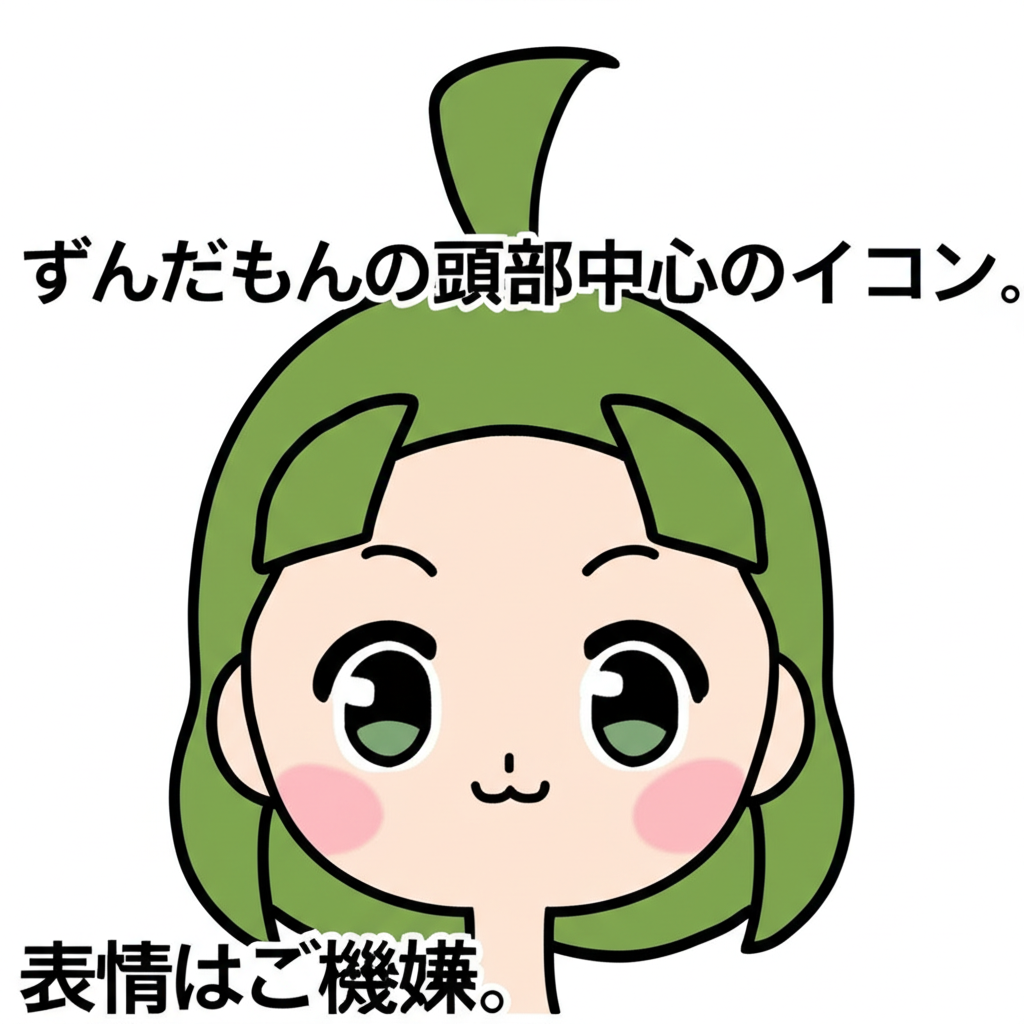

In [10]:
from IPython.display import Image, Markdown

response = client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents='ずんだもんの頭部中心のアイコン。 表情はご機嫌。',
  #  contents='Hi, can create a 3d rendered image of a pig with wings and a top hat flying over a happy futuristic scifi city with lots of greenery?',
    config=types.GenerateContentConfig(
        response_modalities=['Text', 'Image']
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  elif part.inline_data is not None:
    mime = part.inline_data.mime_type
    print(mime)
    data = part.inline_data.data
    display(Image(data=data))

[Imagen](./Get_started_imagen.ipynb) も画像生成の別の方法です。用途ごとの推奨は[ドキュメント](https://ai.google.dev/gemini-api/docs/image-generation#choose-a-model)を参照してください。

## Generate content stream

デフォルトでは、モデルは生成処理が完了してから応答を返します。`generate_content_stream` メソッドを使うと、生成中の応答をストリームとして受け取ることができ、生成された部分から順次返されます。

thinking model を使っている場合、思考処理が終わってからストリーミングが始まる点に注意してください。

In [ ]:
for chunk in client.models.generate_content_stream(
    model=MODEL_ID,
    contents="Tell me a story about a lonely robot who finds friendship in a most unexpected place."
):
  print(chunk.text)
  print("*****************")

## Send asynchronous requests

`client.aio` では、`client` で利用できるすべての非同期メソッドが提供されています。

たとえば、`client.aio.models.generate_content` は `client.models.generate_content` の非同期版です。

In [ ]:
response = await client.aio.models.generate_content(
    model=MODEL_ID,
    contents="Compose a song about the adventures of a time-traveling squirrel."
)

Markdown(response.text)

## Function calling

[Function calling](https://ai.google.dev/gemini-api/docs/function-calling) を使うと、モデルがユーザーのプロンプトに応じて利用できるツール群を提供できます。コード内で関数の説明を作成し、その説明をリクエストで言語モデルに渡します。モデルの応答には次が含まれます：
- 説明に合致する関数名
- 呼び出しに使う引数

In [ ]:
get_destination = types.FunctionDeclaration(
    name="get_destination",
    description="Get the destination that the user wants to go to",
    parameters={
        "type": "OBJECT",
        "properties": {
            "destination": {
                "type": "STRING",
                "description": "Destination that the user wants to go to",
            },
        },
    },
)

destination_tool = types.Tool(
    function_declarations=[get_destination],
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents="I'd like to travel to Paris.",
    config=types.GenerateContentConfig(
        tools=[destination_tool],
        temperature=0,
        ),
)

response.candidates[0].content.parts[0].function_call

## Code execution

[Code execution](https://ai.google.dev/gemini-api/docs/code-execution?lang=python) を使うと、モデルが複雑な質問に答えるための Python コードを生成・実行できます。詳細な例は [Code execution クイックスタートガイド](./Code_execution.ipynb) を参照してください。

In [ ]:
from IPython.display import Image, Markdown, Code, HTML

response = client.models.generate_content(
    model=MODEL_ID,
    contents="Generate and run a script to count how many letter r there are in the word strawberry",
    config = types.GenerateContentConfig(
        tools=[types.Tool(code_execution=types.ToolCodeExecution)]
    )
)

for part in response.candidates[0].content.parts:
  if part.text is not None:
    display(Markdown(part.text))
  if part.executable_code is not None:
    code_html = f'<pre style="background-color: green;">{part.executable_code.code}</pre>'
    display(HTML(code_html))
  if part.code_execution_result is not None:
    display(Markdown(part.code_execution_result.output))
  if part.inline_data is not None:
    display(Image(data=part.inline_data.data, format="png"))
  display(Markdown("---"))

## Upload files

マルチモーダルプロンプトの送信方法を学んだので、さまざまなマルチメディアタイプのファイルを API にアップロードしてみましょう。前述のマルチモーダル例のような小さな画像の場合は、プロンプトで Gemini モデルにローカルファイルを直接指定できます。大きなファイルや複数ファイル、何度も送信したくないファイルは File Upload API を使い、参照で渡します。

大きなテキストファイル、画像、動画、音声の場合は、プロンプトに含める前に File API でアップロードしてください。

### Upload an image file

この例を実行すると、"jetpack.png" 画像のローカルコピーが Python スクリプトの実行ディレクトリに保存されます。

In [ ]:
# Prepare the file to be uploaded
IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png"  # @param {type: "string"}
img_bytes = requests.get(IMG).content

img_path = pathlib.Path('jetpack.png')
img_path.write_bytes(img_bytes)

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=img_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Write a short and engaging blog post based on this picture.",
    ]
)

Markdown(response.text)

### Upload text file

まずはテキストファイルをアップロードします。この例では [Apollo 11](https://www.nasa.gov/history/alsj/a11/a11trans.html) の400ページのトランスクリプトを使用します。

In [ ]:
# Prepare the file to be uploaded
TEXT = "https://storage.googleapis.com/generativeai-downloads/data/a11.txt"  # @param {type: "string"}
text_bytes = requests.get(TEXT).content

text_path = pathlib.Path('a11.txt')
text_path.write_bytes(text_bytes)

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=text_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you give me a summary of this information please?",
    ]
)

Markdown(response.text)

### Upload a PDF file

この PDF ページは、Google Research Blog で公開されている [Smoothly editing material properties of objects](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) という記事です。

まず、URL から PDF ファイルをダウンロードし、ローカルに "article.pdf" として保存します。

In [ ]:
# Prepare the file to be uploaded
PDF = "https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf"  # @param {type: "string"}
pdf_bytes = requests.get(PDF).content

pdf_path = pathlib.Path('article.pdf')
pdf_path.write_bytes(pdf_bytes)

Secondly, you'll upload the saved PDF file and generate a bulleted list summary of its contents.

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=pdf_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Can you summarize this file as a bulleted list?",
    ]
)

Markdown(response.text)

### Upload an audio file

この例では、ジョン・F・ケネディ大統領の1961年一般教書演説の[録音](https://www.jfklibrary.org/asset-viewer/archives/jfkwha-006)を使用します。

In [ ]:
# Prepare the file to be uploaded
AUDIO = "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"  # @param {type: "string"}
audio_bytes = requests.get(AUDIO).content

audio_path = pathlib.Path('audio.mp3')
audio_path.write_bytes(audio_bytes)

In [ ]:
# Upload the file using the API
file_upload = client.files.upload(file=audio_path)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        file_upload,
        "Listen carefully to the following audio file. Provide a brief summary",
    ]
)

Markdown(response.text)

### Upload a video file

この例では、[Big Buck Bunny](https://peach.blender.org/about/) の短いクリップを使用します。

In [ ]:
# Download the video file
VIDEO_URL = "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"  # @param {type: "string"}
video_file_name = "BigBuckBunny_320x180.mp4"
!wget -O {video_file_name} $VIDEO_URL

Let's start by uploading the video file.

In [ ]:
# Upload the file using the API
video_file = client.files.upload(file=video_file_name)
print(f"Completed upload: {video_file.uri}")

> **Note:** 動画の状態が重要です。動画の処理が完了するまで状態を確認してください。動画の状態が `ACTIVE` になったら `generate_content` に渡せます。

In [ ]:
import time

# Check the file processing state
while video_file.state == "PROCESSING":
    print('Waiting for video to be processed.')
    time.sleep(10)
    video_file = client.files.get(name=video_file.name)

if video_file.state == "FAILED":
  raise ValueError(video_file.state)
print(f'Video processing complete: ' + video_file.uri)

In [ ]:
print(video_file.state)

In [ ]:
# Ask Gemini about the video
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        video_file,
        "Describe this video.",
    ]
)

Markdown(response.text)

### Process a YouTube link

For YouTube links, you don't need to explicitly upload the video file content, but you do need to explicitly declare the video URL you want the model to process as part of the `contents` of the request. For more information see the [vision](https://ai.google.dev/gemini-api/docs/vision?lang=python#youtube) documentation including the features and limits.

> **Note:** You're only able to submit up to one YouTube link per `generate_content` request.

> **Note:** If your text input includes YouTube links, the system won't process them, which may result in incorrect responses. To ensure proper handling, explicitly provide the URL using the `file_uri` parameter in `FileData`.

The following example shows how you can use the model to summarize the video. In this case use a summary video of [Google I/O 2024]("https://www.youtube.com/watch?v=WsEQjeZoEng").

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents= types.Content(
        parts=[
            types.Part(text="Summarize this video."),
            types.Part(
                file_data=types.FileData(file_uri='https://www.youtube.com/watch?v=WsEQjeZoEng')
            )
        ]
    )
)

Markdown(response.text)

## Use context caching

[Context caching](https://ai.google.dev/gemini-api/docs/caching?lang=python) を使うと、頻繁に使う入力トークンを専用キャッシュに保存し、以降のリクエストで参照できます。これにより、同じトークンセットを何度もモデルに渡す必要がなくなります。

コンテキストキャッシュは、固定バージョンの安定モデル（例：`gemini-1.5-flash-002`）でのみ利用できます。バージョンのポストフィックス（例：`-002`）を必ず含めてください。より多くのキャッシュ例は[こちら](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Caching.ipynb)を参照してください。

#### Create a cache

In [ ]:
system_instruction = """
  You are an expert researcher who has years of experience in conducting systematic literature surveys and meta-analyses of different topics.
  You pride yourself on incredible accuracy and attention to detail. You always stick to the facts in the sources provided, and never make up new facts.
  Now look at the research paper below, and answer the following questions in 1-2 sentences.
"""

urls = [
    'https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2312.11805v3.pdf',
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2403.05530.pdf",
]

In [ ]:
# Download files
pdf_bytes = requests.get(urls[0]).content
pdf_path = pathlib.Path('2312.11805v3.pdf')
pdf_path.write_bytes(pdf_bytes)

pdf_bytes = requests.get(urls[1]).content
pdf_path = pathlib.Path('2403.05530.pdf')
pdf_path.write_bytes(pdf_bytes)

In [ ]:
# Upload the PDFs using the File API
uploaded_pdfs = []
uploaded_pdfs.append(client.files.upload(file='2312.11805v3.pdf'))
uploaded_pdfs.append(client.files.upload(file='2403.05530.pdf'))

In [ ]:
# Create a cache with a 60 minute TTL
cached_content = client.caches.create(
    model=MODEL_ID,
    config=types.CreateCachedContentConfig(
      display_name='research papers', # used to identify the cache
      system_instruction=system_instruction,
      contents=uploaded_pdfs,
      ttl="3600s",
  )
)

cached_content

#### Listing available cache objects

In [ ]:
for cache in client.caches.list():
  print(cache)

#### Use a cache

In [ ]:
response = client.models.generate_content(
  model=MODEL_ID,
  contents="What is the research goal shared by these research papers?",
  config=types.GenerateContentConfig(cached_content=cached_content.name)
)

Markdown(response.text)

#### Delete a cache

In [ ]:
result = client.caches.delete(name=cached_content.name)

## Get text embeddings

`embed_content` メソッドと `gemini-embedding-exp-03-07` モデルを使って、テキストの埋め込みを取得できます。

Gemini Embeddings モデルはデフォルトで3072次元の出力を生成しますが、1～3072の範囲で出力次元数を選択できます。詳細は[埋め込みガイド](https://ai.google.dev/gemini-api/docs/embeddings)を参照してください。

In [ ]:
TEXT_EMBEDDING_MODEL_ID = "gemini-embedding-exp-03-07"

In [ ]:
response = client.models.embed_content(
    model=TEXT_EMBEDDING_MODEL_ID,
    contents=[
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?"
        ],
    config=types.EmbedContentConfig(output_dimensionality=512)
)

print(response.embeddings)

You'll get a set of three embeddings, one for each piece of text you passed in:

In [ ]:
len(response.embeddings)

You can also see the length of each embedding is 512, as per the `output_dimensionality` you specified.

In [ ]:
print(len(response.embeddings[0].values))
print((response.embeddings[0].values[:4], '...'))

## Next Steps

### Useful API references:

新しい SDK の詳細は [Google GenAI SDK](https://github.com/googleapis/python-genai) をご覧ください。

### Related examples

Gemini 2.0 のより詳細な例は [cookbook の Gemini 2.0 フォルダ](https://github.com/google-gemini/cookbook/tree/main/gemini-2/) を参照してください。[Live API](./Get_started_LiveAPI.ipynb) の使い方、[複数ツールの活用例](../examples/LiveAPI_plotting_and_mapping.ipynb)、Gemini 2.0 の[空間理解](./Spatial_understanding.ipynb)機能なども学べます。

また、思考過程を明示的に示し、より複雑な推論ができる [experimental Gemini 2.0 Flash Thinking](./Get_started_thinking.ipynb) モデルもご覧ください。